In [23]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
sns.set_theme()

This project is divided in 2 parts: we deal with the first case with 1 asset following a GBM and show how we can price a barrier contract on this asset using MC and different numerical techniques. We follow the pdf organization that is included in the repository.

# Part 1: The single asset case

The first step is to create a benchmark function to price those continuous barrier contracts: we use the closed form formula for a down-and-out call option (see pdf sec 1.1.2)

In [8]:
def Call_BS(S,K,T,r,sigma):
    d_plus=(np.log(S/K)+ (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d_moins=d_plus-sigma*np.sqrt(T)
    return S*sp.stats.norm.cdf(d_plus)-K*np.exp(-r*T)*sp.stats.norm.cdf(d_moins)

In [9]:
Call_BS(100,105,1,0.05,0.3)

11.976881462184025

In [17]:
def DAO_BS(S,B,K,T,r,sigma):
    if B>=S:
        return 0
    first_part=Call_BS(S,K,T,r,sigma)
    second_part=(S/B)**(1-2*r/(sigma**2))*Call_BS(B**2/S,K,T,r,sigma)
    return first_part-second_part

In [19]:
DAO_BS(100,95,105,1,0.05,0.3)

4.861415484994472

The function DAO_BS is our benchmark: we will now follow the sections of the pdf to try and re-price those contracts using MC simulations and other numerical techniques. The first step is to create the MC engine:

In [20]:
def simulate_BM_Single(S,T,r,sigma,M,N):
    
    dt=T/(M-1)
    W_1=np.random.normal(loc=0,scale=np.sqrt(dt),size=(N,M))

    S1=np.zeros((N,M))
    S1[:,0]=S
    for i in range(1,M):
        S1[:,i]=S1[:,i-1]*(1+r*dt+sigma*W_1[:,i]) 
    return S1

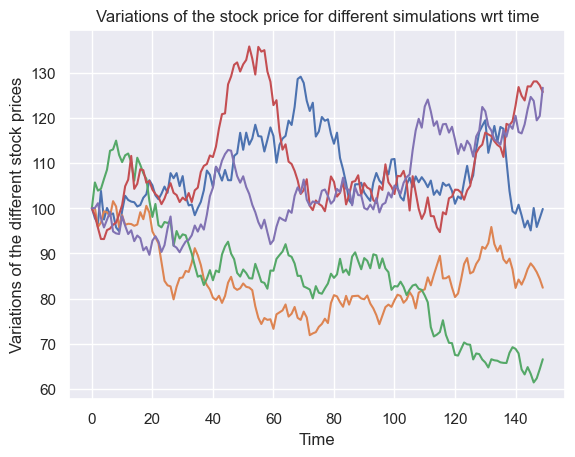

In [28]:
res=simulate_BM_Single(100,1,0.05,0.3,150,5)
for x in res:
    plt.plot(np.arange(len(x)),x)
plt.xlabel("Time")
plt.ylabel("Variations of the different stock prices")
plt.title("Variations of the stock price for different simulations wrt time")
plt.show()

## 1.1 The naive pricing procedure

We define the naive pricing function using this MC engine

In [104]:
def DAO_MC_single_naive(S,B,K,T,r,sigma,M,N):
    tab=simulate_BM_Single(S,T,r,sigma,M,N)
    condition = np.any(tab[:, 1:] < B, axis=1)
    filtered_array = tab[~condition]
    price_tab=np.exp(-r*T)*np.maximum(filtered_array[:,-1]-K,0)
    return sum(price_tab)/N

Outlining the results 1.2.3, we show that this is an inefficient way of pricing those barrier options

In [57]:
S=100
K=100
T=1
sigma=0.3
r=.05
B=95
N=10_000
M=366

In [58]:
DAO_MC_single_naive(S,B,K,T,r,sigma,M,N)

6.1131717074954155

In [59]:
price_tab=[]
for i in range(100):
    price_tab.append(DAO_MC_single_naive(S,B,K,T,r,sigma,M,N))

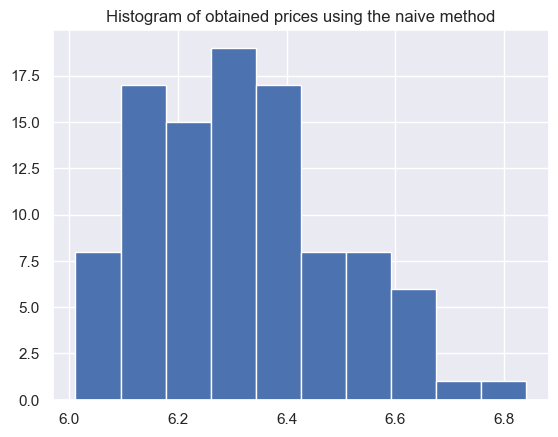

Mean price with benchmark is 5.50 
Mean price with naive pricing is 6.32 


In [67]:
plt.hist(price_tab)
plt.title("Histogram of obtained prices using the naive method")
plt.show()
print("Mean price with benchmark is {:.2f} ".format(DAO_BS(S,B,K,T,r,sigma)))
print("Mean price with naive pricing is {:.2f} ".format(np.array(price_tab).mean()))

The price is way off compared with the benchmark and this does not scale well with M (see pdf 1.2.4): this motivates the use of numerical techniques to complement the MC techniques

# 1.2 The Brownian bridge method

Following section 1.3.1 of the pdf, we implement the brownian bridge method that offsets the bias introduced by the Monte-Carlo method and the Euler-Maruyama scheme

In [71]:
def DAO_MC_single_BB(S,B,K,T,r,sigma,M,N):
    '''
    Estimate the option price using the discrete monitoring of the barrier with Brownian Bridge.

    Inputs:
    - S: The asset price at time 0.
    - B: The lower barrier value. Default is 0.
    - K: The strike .
    - T: The time to maturity.
    - r: The risk-free interest rate.  
    - sigma: The volatility of the underlying asset.
    - M: Time discretization.
    - N: number of paths simulated.
    Output:
    - Option price estimate.

    '''
    tab=simulate_BM_Single(S,T,r,sigma,M,N)
    dt = T/(M-1)
    
    condition = np.any(tab[:, 1:] < B, axis=1)  # Check the condition for the lower barrier

    filtered_array = tab[~condition]  # Filter out the observations that breach the lower barrier

    filt_array_shift = np.roll(filtered_array, -1)  # Shift the filtered array

    # Compute the probability array using Brownian Bridge method
    prob_tab = 1 - np.exp(-2 * np.log(filtered_array / B) * np.log(filt_array_shift / B) / (sigma**2 * dt))
    prob_tab = np.cumprod(prob_tab[:, :-1], axis=1)[:, -1]

    option_price = np.exp(-r * T) * 1 / N * np.sum(np.maximum(filtered_array[:, -1] - K, 0) * prob_tab)


    return option_price


In [85]:
S=100
K=100
T=364/365
sigma=0.3
r=.05
B=95
N=10_000
M=52

In [86]:
price_tab=[]
for i in range(100):
    price_tab.append(DAO_MC_single_BB(S,B,K,T,r,sigma,M,N))

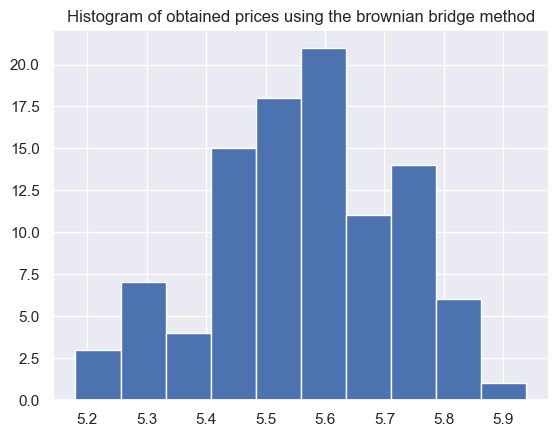

Mean price with benchmark is 5.50 
Mean price with BB pricing is 5.56 


In [87]:
plt.hist(price_tab)
plt.title("Histogram of obtained prices using the brownian bridge method")
plt.show()
print("Mean price with benchmark is {:.2f} ".format(DAO_BS(S,B,K,T,r,sigma)))
print("Mean price with BB pricing is {:.2f} ".format(np.array(price_tab).mean()))

The closer the barrier level to the initial spot price, the harder it is to price the contracts. Yet the BB method still allows for accurate pricing even in difficult configurations:

In [88]:
B=99

In [89]:
price_tab=[]
for i in range(100):
    price_tab.append(DAO_MC_single_BB(S,B,K,T,r,sigma,M,N))

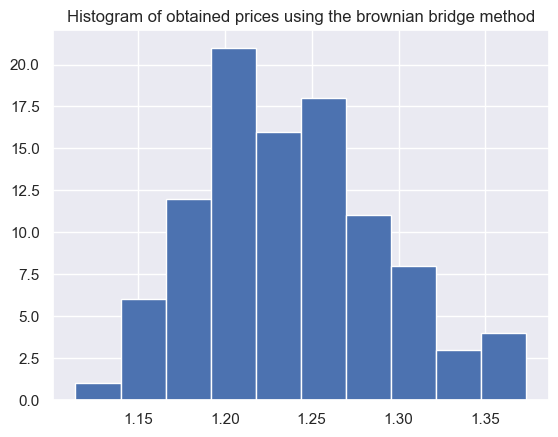

Mean price with benchmark is 1.23 
Mean price with BB pricing is 1.24 


In [90]:
plt.hist(price_tab)
plt.title("Histogram of obtained prices using the brownian bridge method")
plt.show()
print("Mean price with benchmark is {:.2f} ".format(DAO_BS(S,B,K,T,r,sigma)))
print("Mean price with BB pricing is {:.2f} ".format(np.array(price_tab).mean()))

# 1.3 The barrier shifting methods

Following section 1.3.2 of the pdf, we implement the barrier shifting methods that (are supposed to) offset the bias introduced by the Monte-Carlo method and the Euler-Maruyama scheme

Starting with the BASt method that simply moves the barrier level using the 0.5826.. constant

In [95]:
def DAO_MC_single_BAST(S,B,K,T,r,sigma,M,N):
    '''
    Estimate the option price using the discrete monitoring of the barrier with BAST

    Inputs:
    - S: The asset price at time 0.
    - B: The lower barrier value. Default is 0.
    - K: The strike .
    - T: The time to maturity.
    - r: The risk-free interest rate.  
    - sigma: The volatility of the underlying asset.
    - M: Time discretization.
    - N: number of paths simulated.
    Output:
    - Option price estimate.

    '''
    dt = T /(M-1)
    beta = 0.5826
    barrier_shift = B * np.exp(sigma * beta * np.sqrt(dt))
    return DAO_MC_single_naive(S,barrier_shift,K,T,r,sigma,M,N)


In [106]:
DAO_MC_single_BAST(S,B,K,T,r,sigma,M,N)

5.555242217036299

In [107]:
S=100
K=100
T=364/365
sigma=0.3
r=.05
B=95
N=10_000
M=52

In [108]:
price_tab=[]
for i in range(100):
    price_tab.append(DAO_MC_single_BAST(S,B,K,T,r,sigma,M,N))

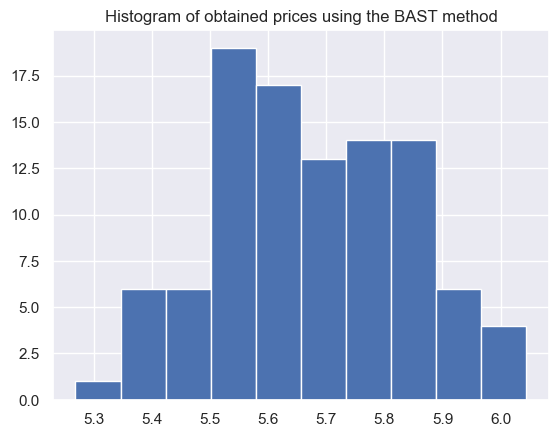

Mean price with benchmark is 5.50 
Mean price with BAST pricing is 5.68 


In [109]:
plt.hist(price_tab)
plt.title("Histogram of obtained prices using the BAST method")
plt.show()
print("Mean price with benchmark is {:.2f} ".format(DAO_BS(S,B,K,T,r,sigma)))
print("Mean price with BAST pricing is {:.2f} ".format(np.array(price_tab).mean()))

However this method is less accurate and reliable than the Brownian bridge method (see section 1.3.2): for example when the barrier is close to the spot price (relative to the time step and volatility):

In [110]:
B=99

In [111]:
price_tab=[]
for i in range(100):
    price_tab.append(DAO_MC_single_BAST(S,B,K,T,r,sigma,M,N))

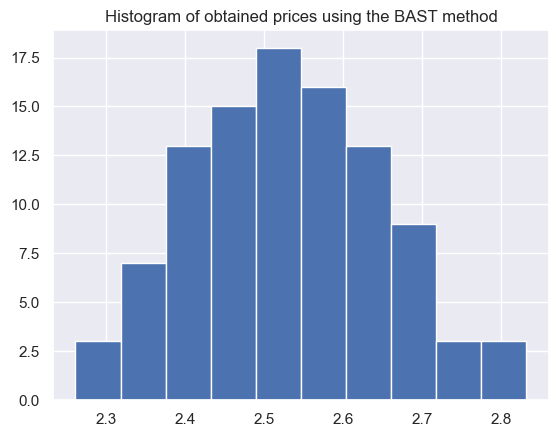

Mean price with benchmark is 1.23 
Mean price with BAST pricing is 2.53 


In [112]:
plt.hist(price_tab)
plt.title("Histogram of obtained prices using the BAST method")
plt.show()
print("Mean price with benchmark is {:.2f} ".format(DAO_BS(S,B,K,T,r,sigma)))
print("Mean price with BAST pricing is {:.2f} ".format(np.array(price_tab).mean()))

And this is way off. A way to deal with this is to take into account this relative distance spot/barrier to modify the constant 0.5826..: this is the abast method. As we show in the paper and here, this is still far from perfect:

In [113]:
def DAO_MC_single_ABAST(S,B,K,T,r,sigma,M,N):
    '''
    Estimate the option price using the discrete monitoring of the barrier with BAST

    Inputs:
    - S: The asset price at time 0.
    - B: The lower barrier value. Default is 0.
    - K: The strike .
    - T: The time to maturity.
    - r: The risk-free interest rate.  
    - sigma: The volatility of the underlying asset.
    - M: Time discretization.
    - N: number of paths simulated.
    Output:
    - Option price estimate.

    '''
    dt = T /(M-1)
    def approximation_Ey(u):
        return 0.5826+0.1245*np.exp(-2.7*u**1.2)
    beta = approximation_Ey(np.log(S/B)/(sigma*np.sqrt(dt)))
    barrier_shift = B * np.exp(sigma * beta * np.sqrt(dt))
    return DAO_MC_single_naive(S,barrier_shift,K,T,r,sigma,M,N)


In [118]:
S=100
K=100
T=364/365
sigma=0.3
r=.05
B=99
N=10_000
M=52

In [119]:
price_tab=[]
for i in range(100):
    price_tab.append(DAO_MC_single_ABAST(S,B,K,T,r,sigma,M,N))

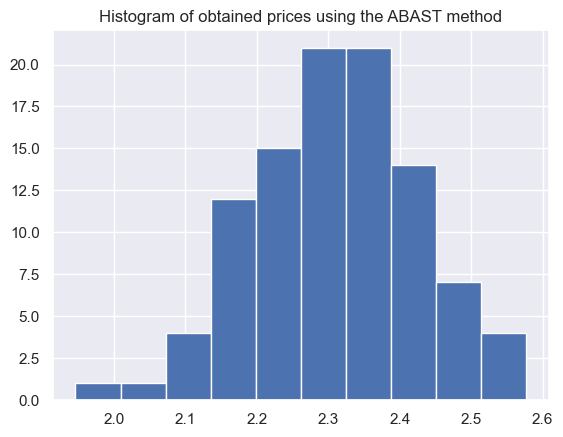

Mean price with benchmark is 1.23 
Mean price with ABAST pricing is 2.31 


In [120]:
plt.hist(price_tab)
plt.title("Histogram of obtained prices using the ABAST method")
plt.show()
print("Mean price with benchmark is {:.2f} ".format(DAO_BS(S,B,K,T,r,sigma)))
print("Mean price with ABAST pricing is {:.2f} ".format(np.array(price_tab).mean()))

Its a bit better but by no mean as good as the brownian bridge method. We could do something more and modify the distance spot/barrier for each time step for each path. Section 1.3.2 however shows it has very little impact on the final price estimate. The barrier shifting method are good approximations but fail for harder configurations.

# Part 2: The multi asset case

This part is more interesting because trying to price multi asset contracts with continuous barrier involves a correlation structure between the assets, hence the need for new techniques: see the pdf for an an outline of the problem

The problem is we do not possess any benchmark function: we therefore rely on existing results. See the papers by Gobet (Advanced Monte Carlo methods for barrier and related exotic options) and by Shevchenko (Addressing the Bias in Monte Carlo Pricing of Multi-Asset Options with Multiple Barriers through Discrete Sampling) for some results. However the copula method is proven to converge to the true price so this is in fact our benchmark.

As previously, we write a function for the MC engine simulations. We choose to work with correlation matrix with constant correlation coefficients, but this does not matter: the results outlined here also apply for other correlation structures (stochastic...)

In [122]:
#This function creates a correlation matrix where d is the number of asset (number of rows) and 
# p is the common correlation between the assets 
def mat_p(d,p):
    Mat=np.eye(d)+p*(np.ones((d,d))-np.eye(d))
    return Mat


In [123]:
def simulate_BM_multi_(Mat,r,S_0,T,vols,M,N):
    '''
    Inputs:
    - Mat: The correlation matrix.
    - r: The risk-free interest rate.
    - S_0: The initial asset prices.
    - T: The time horizon.
    - vols: The volatility function (must be a list of functions)
    - N: The number of simulations.
    - M: The number of time steps.
    
    Output:
    - S: The simulated asset prices.
    '''
    
    d=len(Mat)
    dt=T/(M-1)
    # Generate N(d)-dimensional correlated random numbers
    x=np.random.randint(1,1000)
    rng = np.random.default_rng(x)
    n=int(N*M)
    y = rng.multivariate_normal([0]*d, Mat, size=n)
    x=np.array([y[:,j].reshape(N , M) for j in range(d)])
    x=x*np.sqrt(T/(M-1))
    x[:,:,0]=0
    Col_W=x.cumsum(axis=2)
    # Initialize the asset price matrix
    S=np.zeros((d,N,M))
    # Set the initial asset prices
    for j in range(d):
        S[j][:,0]=S_0[j]
    # Simulate the asset prices
    for j in range(d):
        for i in range(1,M):
            S[j][:,i]=S[j][:,i-1]*(1+r*dt+vols[j]((i-1)*dt,S[j,:,i-1])*(Col_W[j,:,i]-Col_W[j,:,i-1]))
 
    return S

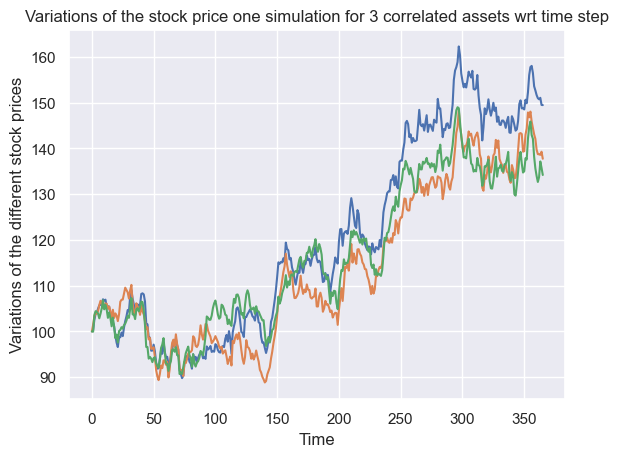

In [139]:
Mat=mat_p(3,0.7)
res=simulate_BM_multi_(Mat,0.05,[100]*3,1,[lambda x,y:0.3]*3,366,1)
for i,_ in enumerate(res):
    plt.plot(np.arange(len(res[i][0])),res[i,0])
plt.xlabel("Time")
plt.ylabel("Variations of the different stock prices")
plt.title("Variations of the stock price one simulation for 3 correlated assets wrt time step")
plt.show()

## 2.1 The naive pricing procedure

Again, we show on an example that the naive pricing procedure of section 2.2 is inefficient in obtaining accurate price

In [153]:
def DAO_MC_NAIVE_MULTI(K, r, S, T, N, vols, lower_bs):
    '''
    Compute the estimation of the price using discrete monitoring of the barrier.

    Inputs:
    - K: The strike price of the option.
    - r: The risk-free interest rate.
    - S: The set of asset prices.
    - T: The time to maturity.
    - N: Step for observations
    - vols: The volatilities of the underlying assets.
    - lower_bs: The lower barriers for each asset.


    Output:
    - Estimation of the option price using discrete monitoring of the barrier.

    '''
    
    S=S[:,:,::N]
    M = len(S[0])
    dt = T / (len(S[0][0]) - 1) * N

    # Check if lower_bs is a scalar or an array
    if isinstance(lower_bs[0], float) or isinstance(lower_bs[0], int):
        is_excluded = np.ones(M)
        for i in range(len(S)):
            condition = np.any( (S[i][:, 1:] < lower_bs[i]), axis=1)
            is_excluded[condition] = 0
        call = S[0][is_excluded == 1][:, -1]
        return np.exp(-r * T) * 1 / M * np.sum(np.maximum(call - K, 0))
    else:
        is_excluded = np.ones(M)
        for i in range(len(S)):
            condition = np.any((S[i][:, 1:] < lower_bs[i][:, 1:]) + (np.isnan(lower_bs[i][:, 1:])), axis=1)
            is_excluded[condition] = 0
        call = S[0][is_excluded == 1][:, -1]
        return np.exp(-r * T) * 1 / M * np.sum(np.maximum(call - K, 0))


In [176]:
S=[100]*3
r=0.05
K=100
T=364/365
N=10000
vols=[lambda x,y:0.4]*3
Bs=[95]*3
p=0.5
Mat=mat_p(3,p)

In [181]:
price_tab=[]
for i in range(500):
    res=simulate_BM_multi_(Mat,r,S,T,vols,52,N)
    price_tab.append(DAO_MC_NAIVE_MULTI(K, r, res, T, 1, vols, Bs))

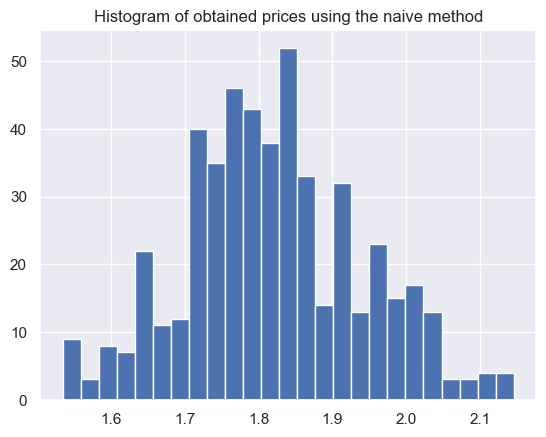

Price with benchmark is 0.77 
Mean price with naive pricing is 1.82 


In [183]:
plt.hist(price_tab,bins=25)
plt.title("Histogram of obtained prices using the naive method")
plt.show()
print("Price with benchmark is {:.2f} ".format(0.77))
print("Mean price with naive pricing is {:.2f} ".format(np.array(price_tab).mean()))

Again, this huge difference motivates the use of other numerical techniques to offset this bias

## 2.2 The copula pricing procedure

Section 2.3.1 of the pdf describes the copula procedure: we basically derive a lower and upper bounds of the price: and their difference shrinks to 0 fast. The implementation follows the Shevchenko article and is described in the pdf section 2.3.1

In [185]:
#Function used to compute the brownian bridge array when the barrier is multi-dimensional (change at each time step)
def eps2(array_or,array_shift,B,vol,dt,flag=0,N=0):
    if flag:
        return np.exp(-2*np.maximum(array_or-B,0)*np.maximum(array_shift-B,0)/(((N*vol)**2)* dt))
    else:
        return np.exp(-2*np.maximum(np.log(array_or/B),0)*np.maximum(np.log(array_shift/B),0)/(vol**2*dt))


In [188]:
def estimator_QL_MA(K, r, S, T, N, vols, lower_bs,flag=False):
    '''
    Compute the lower estimation of the price using Frechet's lower bound.

    Inputs:
    - K: The strike price of the option.
    - r: The risk-free interest rate.
    - S: The set of asset prices.
    - T: The time to maturity.
    - N: Number of observations.
    - vols: The volatilities of the underlying assets.
    - lower_bs: The lower barriers for each asset.

    Output:
    - Lower estimation of the option price.

    '''

    M = len(S[0])
    dt = T / (len(S[0][0]) - 1)*N
    is_excluded = np.ones(M)
    S=S[:,:,::N]
    
    is_excluded=np.ones(len(S[0]))
    prob_tab = np.zeros(S[0][:,:-1].shape)
    for i in range(len(S)):
        con=np.any(S[i,:,::N]<lower_bs[i],axis=1)
        is_excluded[con==True]=0
        array_shift = np.roll(S[i], -1)
        x_values = np.arange(0, len(S[i][0]), 1) * dt
        x = np.repeat(x_values, len(S[i]), axis=0).reshape((len(x_values), len(S[i]))).transpose()
        vol=vols[i](x,S[i])
        prob_tab += eps2(S[i], array_shift, lower_bs[i],vol,dt,False)[:,:-1]
        prob_tab[np.isnan(prob_tab)]=0
    prob_tab = np.maximum(1 - prob_tab, 0)


    prob_tab = np.cumprod(prob_tab, axis=1)[:, -1]


    call = S[0][:,-1]

    option_price_tab=np.exp(-r * T) *  np.maximum(call - K, 0)*prob_tab 
    option_price_tab[np.isnan(option_price_tab)]=0
    price=np.exp(-r * T) * 1 / M * np.sum(np.maximum(call - K, 0) * prob_tab)
    if flag:
        return price, option_price_tab
    return np.exp(-r * T) * 1 / M * np.sum(np.maximum(call - K, 0) * prob_tab) 

In [189]:
def estimator_QU_MA(K, r, S, T, N, vols, lower_bs,flag=False):
    '''
    Compute the upper estimation of the price.

    Inputs:
    - K: The strike price of the option.
    - r: The risk-free interest rate.
    - S: The set of asset prices.
    - T: The time to maturity.
    - N: Number of observations.
    - vols: The volatilities of the underlying assets.
    - lower_bs: The lower barriers for each asset.


    Output:
    - Upper estimation of the option price.

    '''

    M = len(S[0])
    dt = T / (len(S[0][0]) - 1)*N
    S=S[:,:,::N]

    is_excluded = np.ones(M)
    prob_tabs = []
    

        
    # Iterate over each asset
    for i in range(len(S)):
        condition = np.any( (S[i] < lower_bs[i]), axis=1)
        is_excluded[condition] = 0
        x_values = np.arange(0, len(S[i][0]), 1) * dt
        x = np.repeat(x_values, len(S[i]), axis=0).reshape((len(x_values), len(S[i]))).transpose()
        vol=vols[i](x,S[i])
        array_shift = np.roll(S[i], -1)
        tp=1 - eps2(S[i], array_shift, lower_bs[i], vol, dt,False)
        tp[np.isnan(tp)]=0
        prob_tabs.append(tp)
    prob_tab = np.minimum.reduce(prob_tabs)
    prob_tab = np.cumprod(prob_tab[:, :-1], axis=1)[:, -1]
    prob_tab = prob_tab
    call = S[0][:, -1]


    
    option_price_tab=np.exp(-r * T) *  np.maximum(call - K, 0)*prob_tab 
    option_price_tab[np.isnan(option_price_tab)]=0
    price=np.exp(-r * T) * 1 / M * np.sum(np.maximum(call - K, 0) * prob_tab) 
    if flag:
        return price, option_price_tab
    return np.exp(-r * T) * 1 / M * np.sum(np.maximum(call - K, 0) * prob_tab) 

In [190]:
S=[100]*3
r=0.05
K=100
T=364/365
N=10000
vols=[lambda x,y:0.4]*3
Bs=[95]*3
p=0.5
Mat=mat_p(3,p)

In [193]:
price_tab=[]
for i in range(500):
    res=simulate_BM_multi_(Mat,r,S,T,vols,52,N)
    price_tab.append(0.5*estimator_QL_MA(K, r, res, T, 1, vols, Bs)+ 0.5*estimator_QL_MA(K, r, res, T, 1, vols, Bs) )

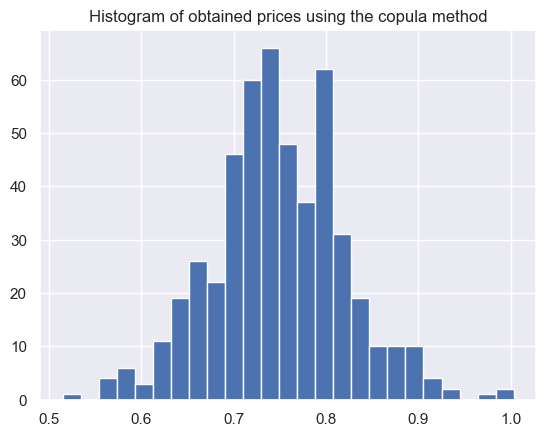

Price with benchmark is 0.77 
Mean price with copula pricing is 0.75 


In [194]:
plt.hist(price_tab,bins=25)
plt.title("Histogram of obtained prices using the copula method")
plt.show()
print("Price with benchmark is {:.2f} ".format(0.77))
print("Mean price with copula pricing is {:.2f} ".format(np.array(price_tab).mean()))

Detailled analysis of the method shows this midpoint estimator is unbiased and converges even when contracts are very hard to price (high barriers/ low strikes). The variance of the estimator however increases with the contract difficulty. This method introduces some overhead because we need two estimators but is still efficient. Moreover, this can handle any type of vol/ interest rates processes (given the MC scheme does not diverge).

## 2.3 The barrier shifting procedure

One advantage of the barrier shifting methods is that, since it only deals with increments of the underlying brownian motions, there is no need to do anything more than for the single asset case. The correlation structure is not needed to compute the price (note however it is still needed to compute the paths). We start again with the BAST method:

In [205]:
def BAST_BO_MA(r, K, S, vol, T, N, lower_b=0):
    '''
    Perform down-and-out multi call option pricing using BAST

    Inputs:
    - r: The risk-free interest rate.
    - K: The strike price of the option.
    - S: The set of asset prices.
    - vol: The volatility of the underlying assets.
    - T: The time to maturity.
    - N: Monitoring time steps.
    - lower_b: The lower barrier value. Default is 0.

    Output:
    - The price of the option

    '''

    dt = T / (len(S[0][0]) - 1) * N
    barrier_shift=np.zeros(len(S))
    for i in range(len(S)):
        beta = 0.5826

        # Compute barrier shift values based on beta and lower_b

        barrier_shift[i] = lower_b[i] * np.exp(vol[i](0,0) * beta * np.sqrt(dt))


    price=DAO_MC_NAIVE_MULTI(K, r, S, T, N, vols, barrier_shift)

    return price


In [219]:
S=[100]*3
r=0.05
K=100
T=364/365
N=10000
vols=[lambda x,y:0.4]*3
Bs=[80]*3
p=0.5
Mat=mat_p(3,p)

In [220]:
price_tab=[]
for i in range(500):
    res=simulate_BM_multi_(Mat,r,S,T,vols,52,N)
    price_tab.append(BAST_BO_MA(r, K, res, vols,T, 1,Bs ))

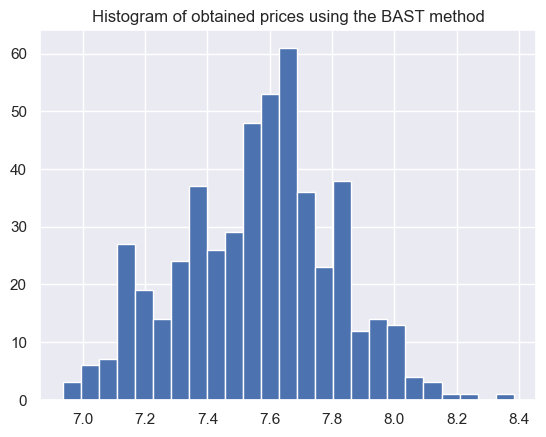

Price with benchmark is 7.60 
Mean price with BAST pricing is 7.56 


In [221]:
plt.hist(price_tab,bins=25)
plt.title("Histogram of obtained prices using the BAST method")
plt.show()
print("Price with benchmark is {:.2f} ".format(7.60))
print("Mean price with BAST pricing is {:.2f} ".format(np.array(price_tab).mean()))

However, and again, the BAST method is not good enough to price complex contracts: here we set B=97 for each asset,K=40 and vol^i=0.3 for all i's.

In [222]:
Bs=[97]*3
K=40
vols=[lambda x,y:0.3]*3
price_tab=[]
for i in range(500):
    res=simulate_BM_multi_(Mat,r,S,T,vols,52,N)
    price_tab.append(BAST_BO_MA(r, K, res, vols,T, 1,Bs ))

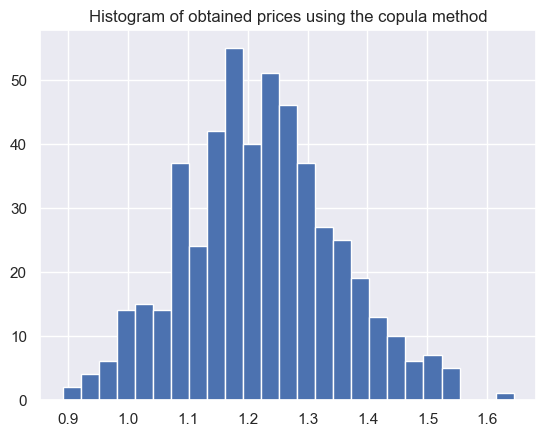

Price with benchmark is 0.90 
Mean price with copula pricing is 1.22 


In [223]:
plt.hist(price_tab,bins=25)
plt.title("Histogram of obtained prices using the BAST method")
plt.show()
print("Price with benchmark is {:.2f} ".format(0.90))
print("Mean price with BAST pricing is {:.2f} ".format(np.array(price_tab).mean()))

The ABAST method, even if it comes closer to the true price, still fails to price accurately those contracts. 

In [230]:
def ABAST_BO_MA(r, K, S, vol, T, N, lower_b=0):
    '''
    Perform down-and-out multi call option pricing using BAST

    Inputs:
    - r: The risk-free interest rate.
    - K: The strike price of the option.
    - S: The set of asset prices.
    - vol: The volatilities of the underlying assets.
    - T: The time to maturity.
    - N: Monitoring time step used.
    - lower_b: The lower barrier value. Default is 0.

    Output:
    - Price of the barrier option

    '''

    dt = T / (len(S[0][0]) - 1) * N
    barrier_shift=[0]*len(S)
    def approximation_Ey(u):
        return 0.5826+0.1245*np.exp(-2.7*u**1.2)
    for i in range(len(S)):
        beta = approximation_Ey(np.log(S[i][0][0]/lower_b[i])/(vol[i](0,0)*np.sqrt(dt)))

        # Compute barrier shift values based on beta and lower_b

        barrier_shift[i] = lower_b[i] * np.exp(vol[i](0,0) * beta * np.sqrt(dt))

    barrier_shift=np.array(barrier_shift)
    price=DAO_MC_NAIVE_MULTI(K, r, S, T, N, vols, barrier_shift)

    return price


In [231]:
price_tab=[]
for i in range(500):
    res=simulate_BM_multi_(Mat,r,S,T,vols,52,N)
    price_tab.append(ABAST_BO_MA(r, K, res, vols,T, 1,Bs ))

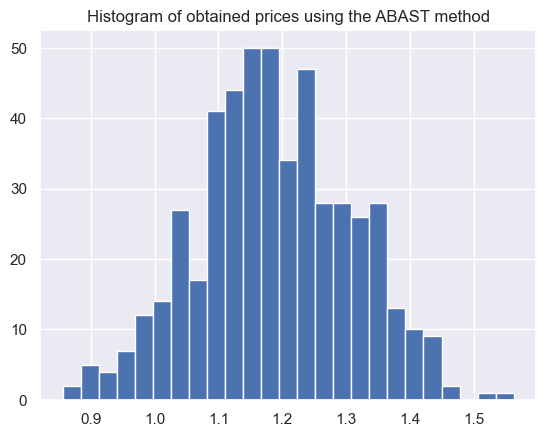

Price with benchmark is 0.90 
Mean price with ABAST pricing is 1.19 


In [232]:
plt.hist(price_tab,bins=25)
plt.title("Histogram of obtained prices using the ABAST method")
plt.show()
print("Price with benchmark is {:.2f} ".format(0.90))
print("Mean price with ABAST pricing is {:.2f} ".format(np.array(price_tab).mean()))

This shows again the barrier shifting techniques fail for difficult cases.

# Part 3: A new approach to price barrier contracts